In [26]:
import jax
import jax.numpy as jnp
import h5py
import matplotlib.pyplot as plt
from PIL import Image
print(jax.devices())

[CpuDevice(id=0)]


- [Jax](#jax-implementaion)

# Data Preprocessing
keep in mind you have `train_catvnoncat.h5` and `test_catvnoncat.h5` in your `sample_data` directory.

In [4]:
def get_dataset():
  r = "dataset"
  train_path = f"{r}/train_catvnoncat.h5"
  test_path = f"{r}/test_catvnoncat.h5"
  f_train, f_test = h5py.File(train_path, "r"), h5py.File(test_path, "r"),
  x_train_orig, y_train_orig = jnp.array(f_train['train_set_x']), jnp.array(f_train["train_set_y"]).reshape(1, -1)
  x_test_orig, y_test_orig = jnp.array(f_test['test_set_x']), jnp.array(f_test["test_set_y"]).reshape(1, -1)
  return x_train_orig, y_train_orig, x_test_orig, y_test_orig

(12288, 209)


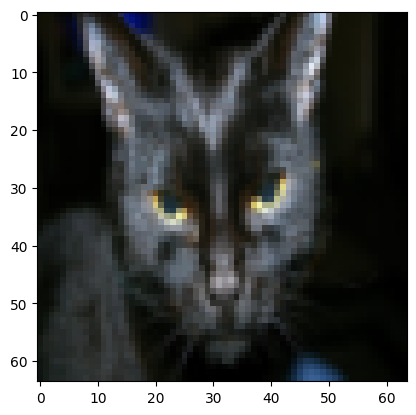

In [5]:
x_train_orig, y_train_orig, x_test_orig, y_test_orig = get_dataset()

x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0], -1).T
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0], -1).T

x_train_norm = x_train_flatten / 255.
x_test_norm = x_test_flatten / 255.

print(x_train_norm.shape)
plt.imshow(x_train_orig[25])

# Jax Implementaion

This version uses Jax library and is faster than the other implementaions thanks to the JIT compilation.

In [6]:
def fc_init_params(inp_dim: int, h_dims: list, verbose = True):
    params = {}
    key = jax.random.PRNGKey(10)
    for i, n in enumerate(h_dims):
        n_prev = h_dims[i - 1] if i else inp_dim
        params[f"W{i + 1}"] = jax.random.normal(key, (n, n_prev)) * jnp.sqrt(2 / n_prev)
        # params[f"W{i + 1}"] = jnp.zeros((n, n_prev))
        params[f"b{i + 1}"] = jnp.zeros((n, 1))
    if verbose:
        print("Network shapes:")
        print("-" * 20)
        for i in range(1, (len(params) // 2) + 1):
            k = f"W{i}"
            print(k, params[k].shape)
        print("-" * 20)
    return params

In [17]:
def sigmoid(z):
    return 1 / (1 + jnp.exp(-z))


def relu(z):
    return jnp.maximum(jnp.zeros(z.shape), z)

def forward(params, x):
    L = len(params) // 2
    a = x
    for i in range(1, L):
        # print(params[f"W{i}"].shape, a.shape)
        a = relu(params[f"W{i}"] @ a + params[f"b{i}"])
    a = sigmoid(params[f"W{L}"] @ a + params[f"b{L}"])
    return a

def logistic_loss(params, x, y):
    m = x.shape[1]
    a = x
    a = forward(params, a)
    l = -(
        jnp.mean(jnp.dot(y, jnp.log(a).T) + jnp.dot((1 - y), jnp.log(1 - a).T)) / m
    )
    return l

@jax.jit
def train_step(params, x, y):

    loss, grads = jax.value_and_grad(logistic_loss)(params, x, y)
    return grads, loss


def train_jax(params, epochs, lr, x, y):
    losses = []
    _lr = lr
    for i in range(epochs):
        grads, loss = train_step(params, x, y)
        if i % 100 == 0:
            print(loss)
            losses.append(loss)
        params = jax.tree_map(lambda p, g: p - (_lr * g), params, grads)
    plt.plot(losses)
    return params

Network shapes:
--------------------
W1 (20, 12288)
W2 (10, 20)
W3 (1, 10)
--------------------
0.68968385
0.5116498
0.4254021
0.36314076
0.28522646
0.18282743
0.25705838
0.090100676
0.045428135
0.03197452
0.023931637
0.01879248
0.015166834
0.012581604
0.010661158
0.009172204
0.008004636
0.0070616445
0.0063010524
0.0056629214
0.0051303445
0.004675489
0.0042884736
0.003957818
0.003664944
0.00340736
0.0031818855
0.0029804863
0.0027988092
0.0026374687
0.0024909792
0.0023579276
0.0022366506
0.0021262781
0.0020251295
0.0019316777
0.0018456815
0.001765594
0.0016913873
0.0016223132
0.0015582844
0.0014990104
0.0014429151
0.0013909767
0.0013420685
0.001296317
0.0012528308
0.0012123446
0.0011738156
0.001137589
0.0011028626
0.0010703435
0.0010391877
0.0010099108
0.0009819453
0.0009555913
0.00093014986
0.000906025
0.0008831067
0.0008610055
0.000839949
0.0008198599
0.000800626
0.0007821235
0.0007644118
0.00074749463
0.0007310237
0.00071533816
0.00070020906
0.00068568485


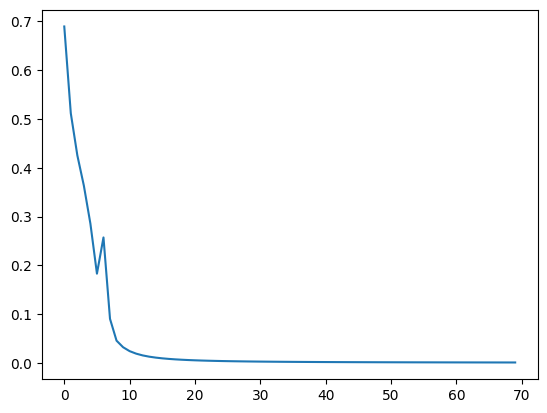

In [8]:
params_new = train_jax(fc_init_params(12288, [20, 10, 1]), 4000, 0.01, x_train_norm, y_train_orig)

# Prediction

RGBA


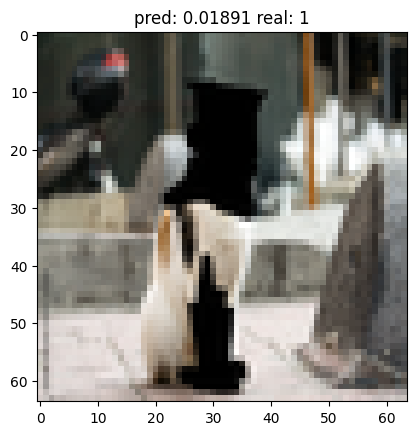

3.9682605


In [52]:
def evaluate(params, x, y, show=True):
    a = forward(params, x)
    if show:
        plt.imshow(x.reshape(64, 64, 3))
        plt.title(f"pred: {a.item():.5f} real: {y.item()}")
        plt.show()
    return logistic_loss(params, x, y)


def open_img(path):
    im = Image.open(path)
    if im.mode != "RGB":
        print(im.mode)
    im = im.convert("RGB")
    im = im.resize((64, 64), Image.Resampling.LANCZOS)
    im.save("test.png")
    x = jnp.asarray(im).reshape(-1, 1) / 255
    return x, jnp.array([[1]])


# i = 10
# x, y = x_test_norm[:, i].reshape(-1, 1), y_test_orig[0, i].reshape(-1, 1)

x, y = open_img("cat4.png")
loss = evaluate(params_new, x, y)
print(loss)